In [1]:
import os
import numpy as np
import itertools
import math, random
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pyedflib
from torch.utils.data import Dataset

from func import *


# Установка Seed для воспроизводимости
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Создание датасета

In [2]:
class ECG_signal_data(Dataset):
    def __init__(self, split='train', transform=None, random_seed=42):
        self.df_gt = pd.read_excel('dataset/1250_ef.xlsx', index_col=0)
        self.df_gt['class'] = self.df_gt['EF'].apply(lambda x: 1 if x < 50 else 0)
        self.ecg_paths = glob(f"dataset/Dataset_larger_1250/FULL_DATA/*.edf")
        self.transform = transform
        self.classes = {0: 'normal', 1: 'pathology'}

        # Разделение данных
        train_paths, val_paths = train_test_split(self.ecg_paths, test_size=0.25, random_state=random_seed)

        if split == 'train':
            self.file_paths = train_paths
        elif split == 'val':
            self.file_paths = val_paths
        else:
            raise ValueError("Invalid split parameter. Use 'train' or 'val'.")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        signal = get_full_signal(file_path)

        if self.transform:
            signal = self.transform(signal)

        target = self.df_gt.loc[os.path.basename(file_path)]['class']

        return {'signal': signal, 'category': target, 'file_edf': os.path.basename(file_path)}


(8, 5000)


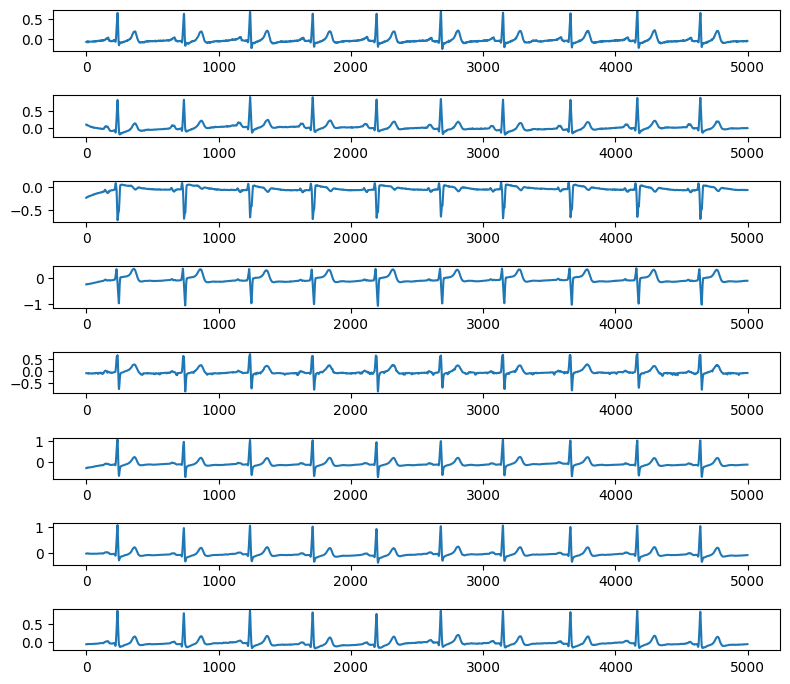

In [3]:
train_ds = ECG_signal_data(split='train', transform=None)
valid_ds = ECG_signal_data(split='val', transform=None)

print(train_ds[0]['signal'].shape)
plot_signals_with_subplot(train_ds[0]['signal'])

# Аугментации создаем тут:

In [4]:
class RandomSubsetTransform:
    def __init__(self, subset_length):
        self.subset_length = subset_length

class RandomSubsetTransform:
    def __init__(self, subset_length):
        self.subset_length = subset_length

    def __call__(self, signal):
        # Генерируем случайный индекс начала подпоследовательности
        len_signal = signal.shape[1]
        start_index = np.random.randint(250, len_signal - self.subset_length - 250)
        # 250 - отступ с двух сторон из-за фильтрации (0.5 с)

        # Выбираем подпоследовательность из сигнала
        subset = signal[:, start_index:start_index + self.subset_length]

        return subset

    
class ToTensor(object):
    def __call__(self, signal):
        return torch.from_numpy(signal)

torch.Size([8, 2048])


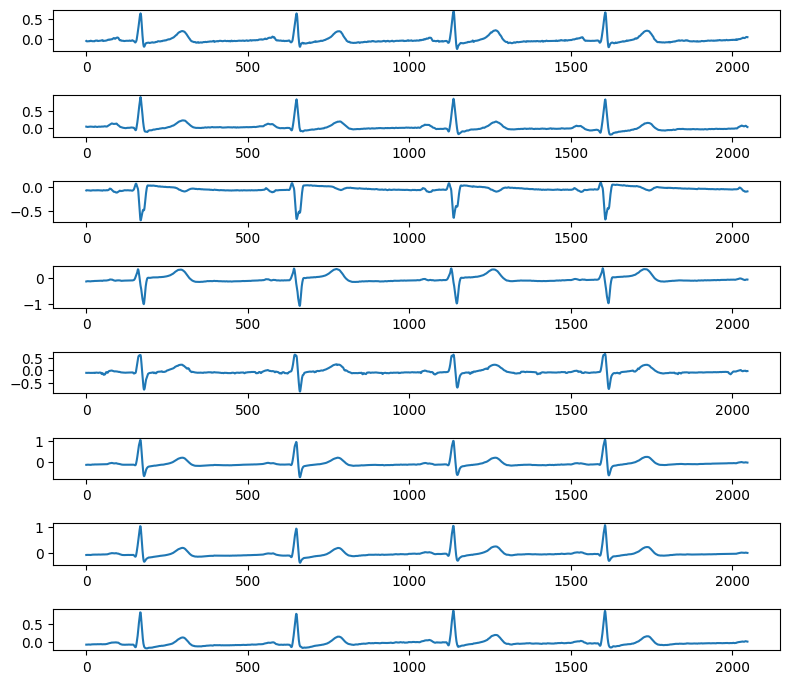

In [5]:
# 2048 - число точек вытягиваемых (примерно 4 с при 500 Гц)
transforms_data = transforms.Compose([
                        RandomSubsetTransform(2048),
                        ToTensor()
                        ])


train_ds = ECG_signal_data(split='train', transform=transforms_data)
valid_ds = ECG_signal_data(split='val', transform=transforms_data)

print(train_ds[0]['signal'].shape)
plot_signals_with_subplot(train_ds[0]['signal'])

---

# Обучение сети

### Как запустить сервер MLflow:
```
mlflow server --backend-store-uri "file:///C:/ML_flow_server" --host localhost --port 5000
```
По этой ссылке будет доступен MLflow: http://localhost:5000

In [6]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("ECG_CNN_Classification")

<Experiment: artifact_location='mlflow-artifacts:/300881519775977736', creation_time=1706127992933, experiment_id='300881519775977736', last_update_time=1706127992933, lifecycle_stage='active', name='ECG_CNN_Classification', tags={}>

> ## RESNET18

In [7]:
from resnet18 import *
BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)

# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 14


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(in_channels=8, num_classes=2)
model.to(device)

ResNet18(
  (conv1): Conv1d(8, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

Запуски обучений:

In [9]:
train_model(model=ResNet18(in_channels=8, num_classes=2),
            dataloader_train=train_loader,
            dataloader_val=valid_loader, batch_size=BATCH_SIZE, 
            name_save='resnet18', start_weight=None, 
            name_experiment='resnet18 with sheduler', lr=1e-4, epochs=35,
            scheduler=True, scheduler_step_size=10, dataset_name='1250_ef',
            f_sampling=500, seed=42, n_points=2048, num_channels=8,
            filt='ФВЧ 0.7 Гц', gamma=0.5, noise_std=0)

Обучение будет производиться на cuda


In [ ]:
train_model(model=ResNet18(in_channels=8, num_classes=2),
            dataloader_train=train_loader,
            dataloader_val=valid_loader, batch_size=BATCH_SIZE, 
            name_save='resnet18', start_weight=None, 
            name_experiment='resnet18 with sheduler', lr=1e-4, epochs=35,
            scheduler=False, dataset_name='1250_ef',
            f_sampling=500, seed=42, n_points=2048, num_channels=8,
            filt='ФВЧ 0.7 Гц', noise_std=0)

> ## RESNET18-SE

In [ ]:
from resnet18_se import *
BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)

# Определение количества итераций в одной эпохе
iterations_per_epoch = len(train_loader)
print('Число градиентных спусков за 1 эпоху раняется', iterations_per_epoch)

Число градиентных спусков за 1 эпоху раняется 14


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18_SE(in_channels=8, num_classes=2)
model.to(device)

Запуски обучений:

In [ ]:
train_model(model=ResNet18_SE(in_channels=8, num_classes=2),
            dataloader_train=train_loader,
            dataloader_val=valid_loader, batch_size=BATCH_SIZE, 
            name_save='resnet18-se', start_weight=None, 
            name_experiment='resnet18 with sheduler', lr=1e-4, epochs=35,
            scheduler=True, scheduler_step_size=10, dataset_name='1250_ef',
            f_sampling=500, seed=42, n_points=2048, num_channels=8,
            filt='ФВЧ 0.7 Гц', gamma=0.5, noise_std=0)

Обучение будет производиться на cuda
Epoch 1/30, Train Loss: 0.6097, Train Aсс: 0.7210 Val Loss: 0.6722, Val Acc:0.6837 
Epoch 5/30, Train Loss: 0.3040, Train Aсс: 0.8538 Val Loss: 0.4523, Val Acc:0.8179 


In [ ]:
train_model(model=ResNet18(in_channels=8, num_classes=2),
            dataloader_train=train_loader,
            dataloader_val=valid_loader, batch_size=BATCH_SIZE, 
            name_save='resnet18-se', start_weight=None, 
            name_experiment='resnet18 with sheduler', lr=1e-4, epochs=35,
            scheduler=False, dataset_name='1250_ef',
            f_sampling=500, seed=42, n_points=2048, num_channels=8,
            filt='ФВЧ 0.7 Гц', noise_std=0)